## SQL Business Analysis Project
Soham Sen | Jan 23, 2018

### A. Import the Packages

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
from datetime import date

%matplotlib inline

### B. Load Data and Set up Functions

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    qry = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(qry)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### 1. Which Artists to Sign based on Genre Popularity

In [6]:
q = '''
SELECT 
    g.name genre,
    SUM(il.quantity) tracks_sold,
    100*SUM(il.quantity)/(SELECT SUM(quantity) FROM invoice_line) AS pct
FROM genre g 
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = "USA"
GROUP BY 1
ORDER BY 2 DESC
'''

tracksByGenre = run_query(q)

tracksByGenre

,genre,tracks_sold,pct
0,Rock,561,11
1,Alternative & Punk,130,2
2,Metal,124,2
3,R&B/Soul,53,1
4,Blues,36,0
5,Alternative,35,0
6,Latin,22,0
7,Pop,22,0
8,Hip Hop/Rap,20,0
9,Jazz,14,0


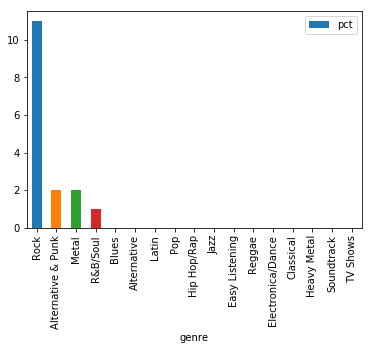

In [7]:
tracksByGenre.plot(kind='bar', x='genre', y='pct')

The analysis suggest that rock, aternative, metal and R&B are by far the highest selling genres. So the artists don't seem like a great fit for Chinook. The Punk artist Red Tone seems like the best of the lot. Then the Blues artist. Po and Hip-hop after that. 

### 2. Analyzing Employee Sales Peformance

In [8]:


q2 = '''
WITH 
    customer_sales AS 
        (
            SELECT c.*, SUM(i.total) total_sales
            FROM customer c
            INNER JOIN invoice i ON i.customer_id = c.customer_id
            GROUP BY c.customer_id
            ORDER BY 2
               
        ),
    rep_sales AS
        (
            SELECT 
                support_rep_id support_rep,
                SUM(total_sales) agg_sales
            FROM customer_sales
            GROUP BY 1
            ORDER BY 2 DESC
        )

SELECT 
    rp.*, 
    e.first_name || ' ' || e.last_name fullname,
    e.title title,
    e.reports_to supervisor,
    e.country,
    e.city,
    e.hire_date
FROM rep_sales rp
INNER JOIN employee e ON e.employee_id = rp.support_rep
'''

repPerf = run_query(q2)
repPerf['hire_date'] = pd.to_datetime(repPerf.hire_date)
repPerf['experience'] = ((date.today() - repPerf.hire_date)/np.timedelta64(1, 'D')).astype(int)
repPerf


,support_rep,agg_sales,fullname,title,supervisor,country,city,hire_date,experience
0,3,1731.51,Jane Peacock,Sales Support Agent,2,Canada,Calgary,2017-04-01,298
1,4,1584.00,Margaret Park,Sales Support Agent,2,Canada,Calgary,2017-05-03,266
2,5,1393.92,Steve Johnson,Sales Support Agent,2,Canada,Calgary,2017-10-17,99


Text(0.5,1,'Sales by Rep')

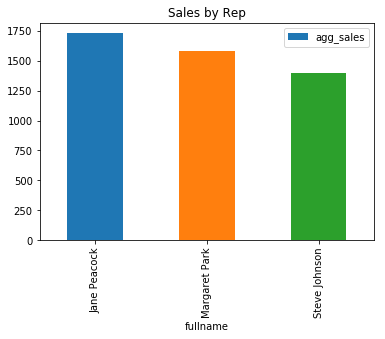

In [9]:
repPerf.plot.bar(x='fullname', y='agg_sales').set_title('Sales by Rep')

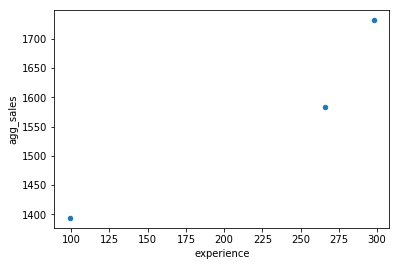

In [10]:
repPerf.plot.scatter(x='experience', y='agg_sales')

Doesn't look like there is that much difference between the three agents. Whatever variation there is is not due to supervisor or location which are same across the three. There does seem to be some correlation betwen experience and performance.

### Analyzing Sales by Country

In [12]:
q3 = '''
WITH 
    order_details AS
        (
            SELECT c.customer_id, i.invoice_id, c.country country1, i.total
            FROM customer c
            INNER JOIN invoice i ON i.customer_id = c.customer_id
        ),
    country_orders AS
        (
            SELECT 
                country1,
                COUNT(DISTINCT customer_id) customer_count,
                SUM(total) total_sales,
                COUNT(invoice_id) total_orders
            FROM order_details
            GROUP BY country1
            ORDER BY 2 DESC

        ),
    country_orders_adj AS
        (
            SELECT
                *,
                CASE
                    WHEN customer_count > 1 THEN country1
                    ELSE "Other"
                END AS country
            FROM country_orders

        ),
        
    country_orders_agg AS
        (
            SELECT
                country,
                total_sales,
                total_sales/customer_count avg_val_customer,
                total_sales/total_orders avg_order_val
            FROM country_orders_adj
            GROUP BY 1
            ORDER BY 2

        )

SELECT * 
FROM country_orders_agg
ORDER BY total_sales DESC
'''

run_query(q3)

,country,total_sales,avg_val_customer,avg_order_val
0,USA,1040.49,80.037692,7.942672
1,Canada,535.59,66.948750,7.047237
2,Brazil,427.68,85.536000,7.011148
3,France,389.07,77.814000,7.781400
4,Germany,334.62,83.655000,8.161463
5,Czech Republic,273.24,136.620000,9.108000
6,United Kingdom,245.52,81.840000,8.768571
7,Portugal,185.13,92.565000,6.383793
8,India,183.15,91.575000,8.721429
9,Other,75.24,75.240000,7.524000


#### Visualizing Data